# SHAP Feature Importance Analysis

**Author:** Prabhu

## Overview

This notebook performs comprehensive SHAP (SHapley Additive exPlanations) analysis to interpret the PD model predictions. SHAP values provide:

1. **Global Feature Importance** - Which features matter most across the portfolio
2. **Local Explanations** - Why individual loans received specific PD predictions
3. **Feature Interactions** - How features work together to influence predictions
4. **Decision Pathways** - Visual trace of how model arrives at predictions

---

## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import shap
import joblib
import warnings
import os
import sys

# Add src to path
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

warnings.filterwarnings('ignore')

# Initialize SHAP JavaScript for interactive plots
shap.initjs()

print("SHAP version:", shap.__version__)

C:\Users\vandrap\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP version: 0.50.0


In [2]:
# Professional chart styling
plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11

# Custom color palette
COLORS = {
    'primary': '#2563eb',
    'secondary': '#dc2626',
    'positive': '#059669',
    'negative': '#dc2626',
    'neutral': '#6b7280'
}

In [3]:
# Paths - Use processed data that already has features and PD predictions
# This data is created by running notebooks 01-05 or run_analysis.py
DATA_PATH = '../data_processed/loans_with_pd.csv'
OUTPUTS_PATH = '../outputs/'
FIGURES_PATH = '../outputs/figures/'

# Load processed data
if os.path.exists(DATA_PATH):
    print("Loading processed data...")
    df = pd.read_csv(DATA_PATH, low_memory=False)
    print(f"Loaded {len(df):,} loans")
    print(f"Columns available: {len(df.columns)}")
else:
    print(f"Data not found at: {DATA_PATH}")
    print("Please run notebooks 01-05 first, or run: python run_analysis.py")

Loading processed data...
Loaded 1,347,680 loans
Columns available: 43


## 2. Data Preparation

In [4]:
# Data is already processed - just verify the required columns exist
# The processed data already has: Default, fico_n, revenue, dti_n, loan_amnt, etc.

required_cols = ['Default', 'fico_n', 'revenue', 'dti_n', 'loan_amnt']
missing = [col for col in required_cols if col not in df.columns]

if missing:
    print(f"Missing columns: {missing}")
    print("Available columns:", df.columns.tolist())
else:
    print(f"All required columns present")
    print(f"Clean data: {len(df):,} records")
    print(f"Default rate: {df['Default'].mean()*100:.2f}%")

All required columns present
Clean data: 1,347,680 records
Default rate: 19.98%


In [5]:
# Features are already engineered in the processed data
# Just verify they exist, or create if missing

# Check if derived features exist, create if not
if 'loan_to_income' not in df.columns:
    df['loan_to_income'] = df['loan_amnt'] / (df['revenue'] + 1)
    df['loan_to_income'] = df['loan_to_income'].replace([np.inf, -np.inf], np.nan)
    df['loan_to_income'] = df['loan_to_income'].fillna(df['loan_to_income'].median())

if 'income_per_dti' not in df.columns:
    df['income_per_dti'] = df['revenue'] / (df['dti_n'] + 1)
    df['income_per_dti'] = df['income_per_dti'].replace([np.inf, -np.inf], np.nan)
    df['income_per_dti'] = df['income_per_dti'].fillna(df['income_per_dti'].median())

if 'fico_bucket_num' not in df.columns:
    fico_bins = [300, 579, 619, 659, 699, 739, 779, 850]
    fico_labels = ['300-579', '580-619', '620-659', '660-699', '700-739', '740-779', '780-850']
    df['fico_bucket'] = pd.cut(df['fico_n'], bins=fico_bins, labels=fico_labels)
    fico_bucket_map = {'300-579': 1, '580-619': 2, '620-659': 3, '660-699': 4,
                       '700-739': 5, '740-779': 6, '780-850': 7}
    df['fico_bucket_num'] = df['fico_bucket'].astype(str).map(fico_bucket_map)
    df['fico_bucket_num'] = pd.to_numeric(df['fico_bucket_num'], errors='coerce').fillna(4)

if 'emp_length_num' not in df.columns:
    emp_length_map = {'< 1 year': 0.5, '1 year': 1, '2 years': 2, '3 years': 3,
                      '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,
                      '8 years': 8, '9 years': 9, '10+ years': 10}
    if 'emp_length' in df.columns:
        df['emp_length_num'] = df['emp_length'].map(emp_length_map)
        df['emp_length_num'] = df['emp_length_num'].fillna(5)  # Default to 5 years
    else:
        df['emp_length_num'] = 5  # Default value

print("Features ready for modeling")

Features ready for modeling


In [6]:
# Feature configuration with display names
FEATURES = {
    'fico_n': 'FICO Score',
    'dti_n': 'DTI Ratio (%)',
    'loan_amnt': 'Loan Amount ($)',
    'revenue': 'Annual Income ($)',
    'loan_to_income': 'Loan-to-Income',
    'income_per_dti': 'Income per DTI',
    'fico_bucket_num': 'FICO Bucket',
    'emp_length_num': 'Employment Years'
}

feature_cols = list(FEATURES.keys())
feature_names = list(FEATURES.values())

# Prepare modeling data
df_model = df[feature_cols + ['Default']].dropna()
print(f"Modeling data: {len(df_model):,} records")

Modeling data: 1,347,680 records


## 3. Train XGBoost Model

In [7]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Prepare data
X = df_model[feature_cols]
y = df_model['Default']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training: {len(X_train):,} | Test: {len(X_test):,}")

Training: 943,376 | Test: 404,304


In [8]:
# Train XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='auc',
    use_label_encoder=False
)

model.fit(X_train, y_train)

# Evaluate
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test AUC: {auc:.4f}")
print(f"Gini: {2*auc-1:.4f}")

Test AUC: 0.6544
Gini: 0.3088


## 4. SHAP Analysis - Premium Visualizations

In [9]:
# Compute SHAP values
sample_size = min(10000, len(X_test))
X_sample = X_test.sample(n=sample_size, random_state=42)

print(f"Computing SHAP values for {sample_size:,} samples...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Create SHAP Explanation object for newer API
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=np.full(len(X_sample), explainer.expected_value),
    data=X_sample.values,
    feature_names=feature_names
)

print("SHAP values computed successfully")

Computing SHAP values for 10,000 samples...
SHAP values computed successfully


### 4.1 Beeswarm Plot - Global Feature Impact

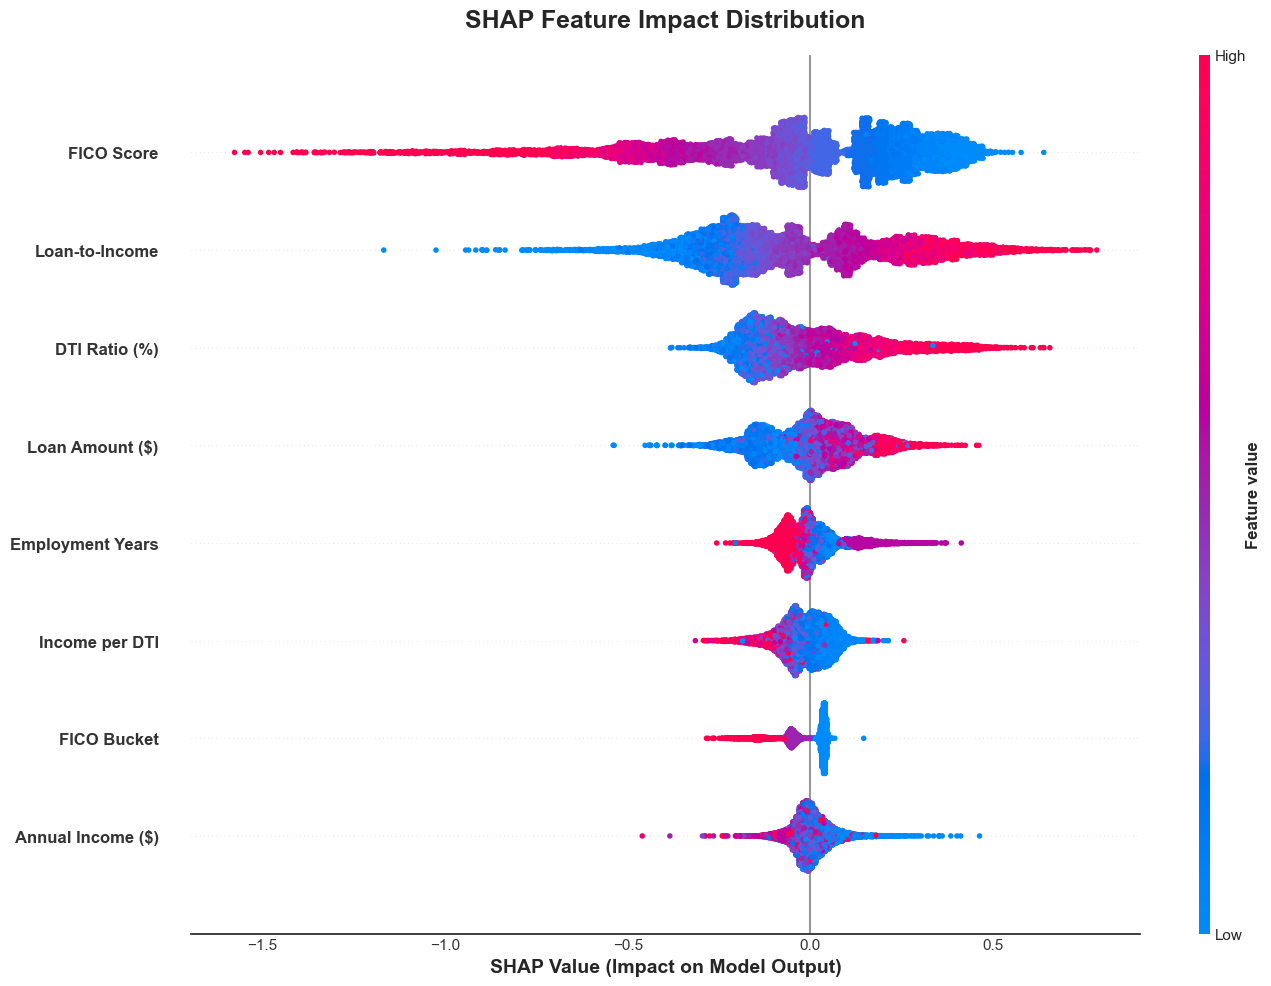

Saved: 24_shap_beeswarm.png


In [10]:
# Premium Beeswarm Plot
fig, ax = plt.subplots(figsize=(14, 10))

shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                  show=False, plot_size=(14, 10))

plt.title('SHAP Feature Impact Distribution', fontweight='bold', fontsize=18, pad=20)
plt.xlabel('SHAP Value (Impact on Model Output)', fontweight='bold', fontsize=14)

# Style improvements
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for label in ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(12)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '24_shap_beeswarm.png'), dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: 24_shap_beeswarm.png")

### 4.2 Bar Plot - Mean Feature Importance

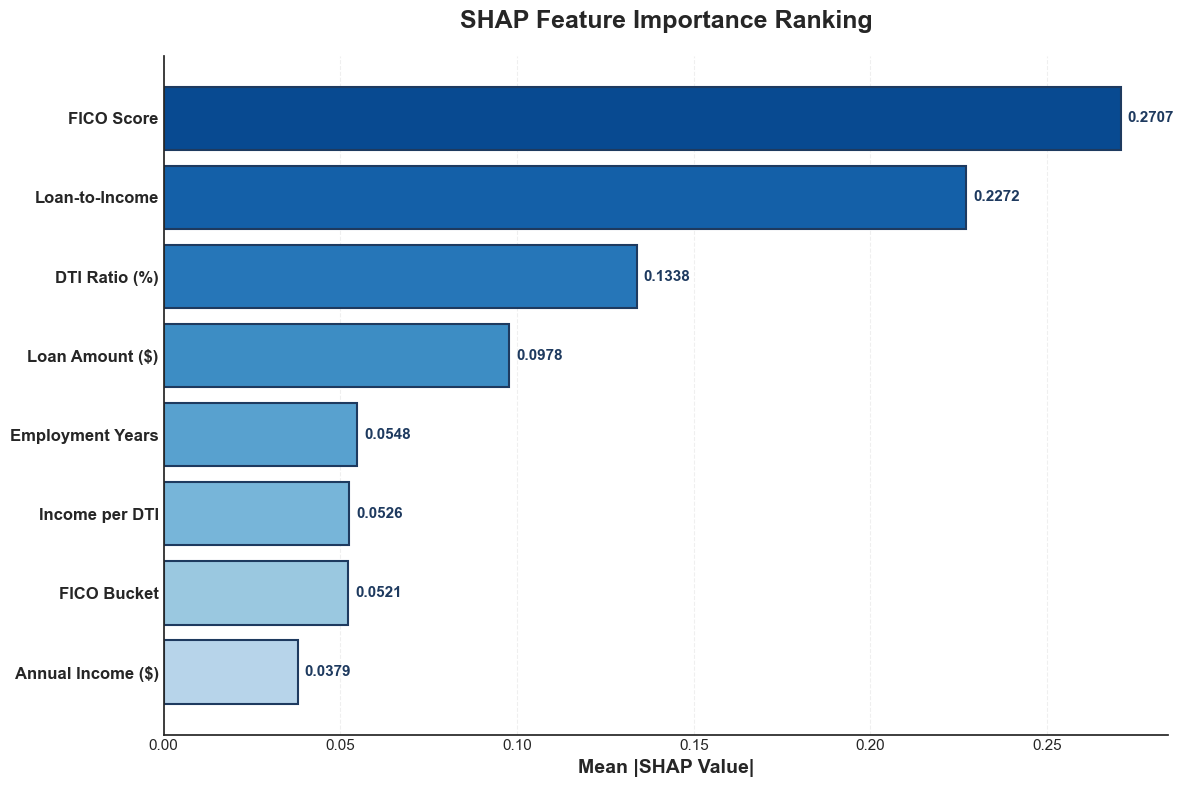

Saved: 25_shap_importance_bar.png


In [11]:
# Custom professional bar plot
mean_shap = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_shap
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))

# Gradient colors
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(importance_df)))

bars = ax.barh(range(len(importance_df)), importance_df['Importance'], 
               color=colors, edgecolor='#1e3a5f', linewidth=1.5)

ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['Feature'], fontweight='bold', fontsize=12)
ax.set_xlabel('Mean |SHAP Value|', fontweight='bold', fontsize=14)
ax.set_title('SHAP Feature Importance Ranking', fontweight='bold', fontsize=18, pad=20)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, importance_df['Importance'])):
    ax.text(val + 0.002, bar.get_y() + bar.get_height()/2, f'{val:.4f}',
            va='center', fontsize=11, fontweight='bold', color='#1e3a5f')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '25_shap_importance_bar.png'), dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: 25_shap_importance_bar.png")

### 4.3 SHAP Heatmap - Feature Contributions Across Samples

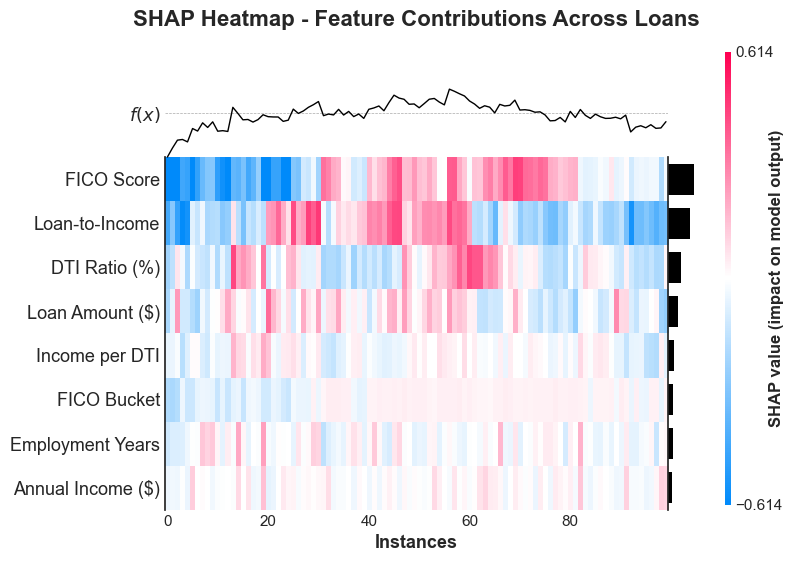

Saved: 26_shap_heatmap.png


In [12]:
# SHAP Heatmap (subset for clarity)
n_display = 100
sample_idx = np.random.choice(len(shap_explanation), n_display, replace=False)
sample_idx = np.sort(sample_idx)

fig, ax = plt.subplots(figsize=(16, 10))
shap.plots.heatmap(shap_explanation[sample_idx], show=False, max_display=8)
plt.title('SHAP Heatmap - Feature Contributions Across Loans', fontweight='bold', fontsize=16, pad=15)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '26_shap_heatmap.png'), dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: 26_shap_heatmap.png")

### 4.4 Dependence Plots - Feature Effect Visualization

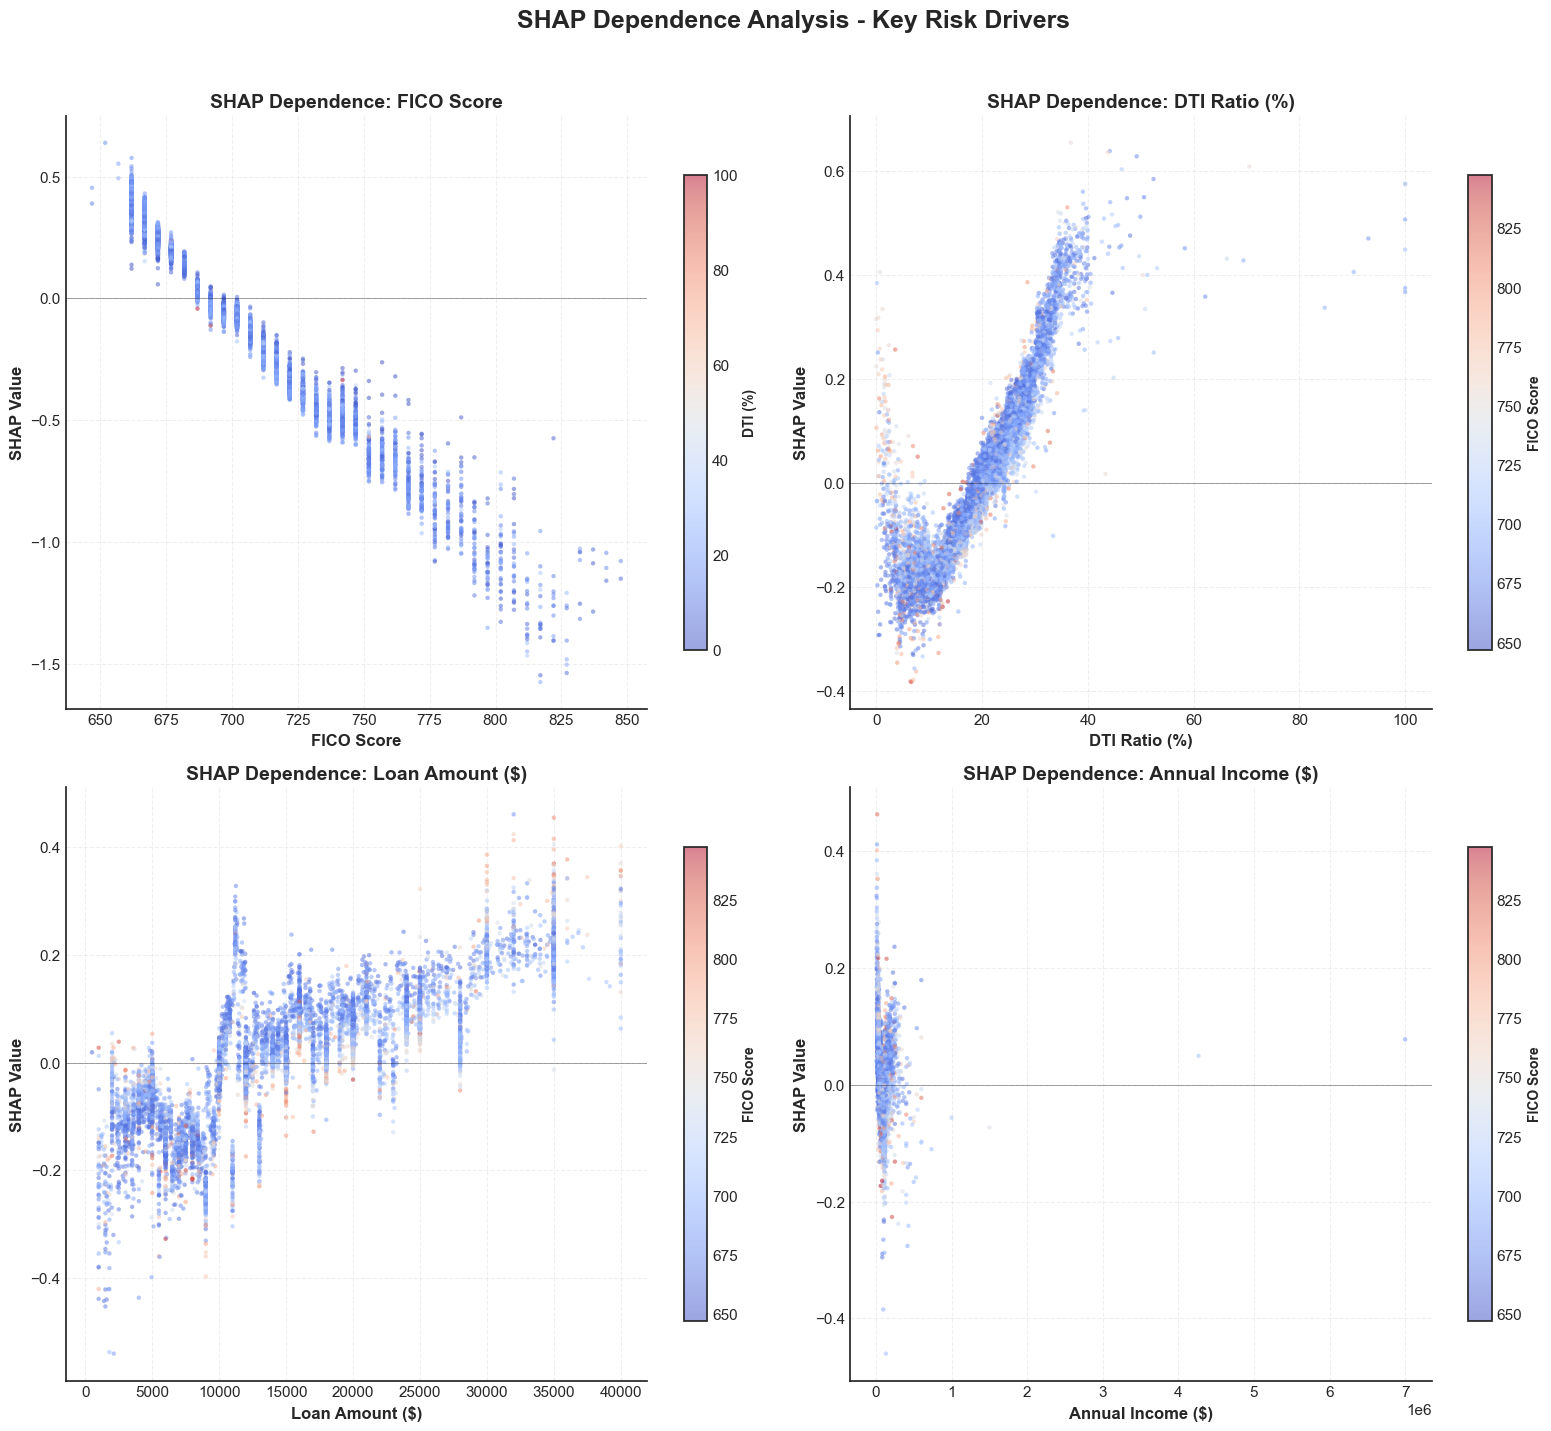

Saved: 27_shap_dependence_multi.png


In [13]:
# Multi-panel dependence plots
key_features = ['fico_n', 'dti_n', 'loan_amnt', 'revenue']
key_names = ['FICO Score', 'DTI Ratio (%)', 'Loan Amount ($)', 'Annual Income ($)']

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for i, (feat, name) in enumerate(zip(key_features, key_names)):
    feat_idx = feature_cols.index(feat)
    
    ax = axes[i]
    
    # Scatter with color based on another interacting feature
    scatter = ax.scatter(X_sample[feat], shap_values[:, feat_idx], 
                        c=X_sample['fico_n'] if feat != 'fico_n' else X_sample['dti_n'],
                        cmap='coolwarm', alpha=0.5, s=10, edgecolors='none')
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.set_xlabel(name, fontweight='bold', fontsize=12)
    ax.set_ylabel('SHAP Value', fontweight='bold', fontsize=12)
    ax.set_title(f'SHAP Dependence: {name}', fontweight='bold', fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Colorbar
    cbar_label = 'DTI (%)' if feat == 'fico_n' else 'FICO Score'
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label(cbar_label, fontweight='bold', fontsize=10)

plt.suptitle('SHAP Dependence Analysis - Key Risk Drivers', fontweight='bold', fontsize=18, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '27_shap_dependence_multi.png'), dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: 27_shap_dependence_multi.png")

### 4.5 SHAP Interaction Plot

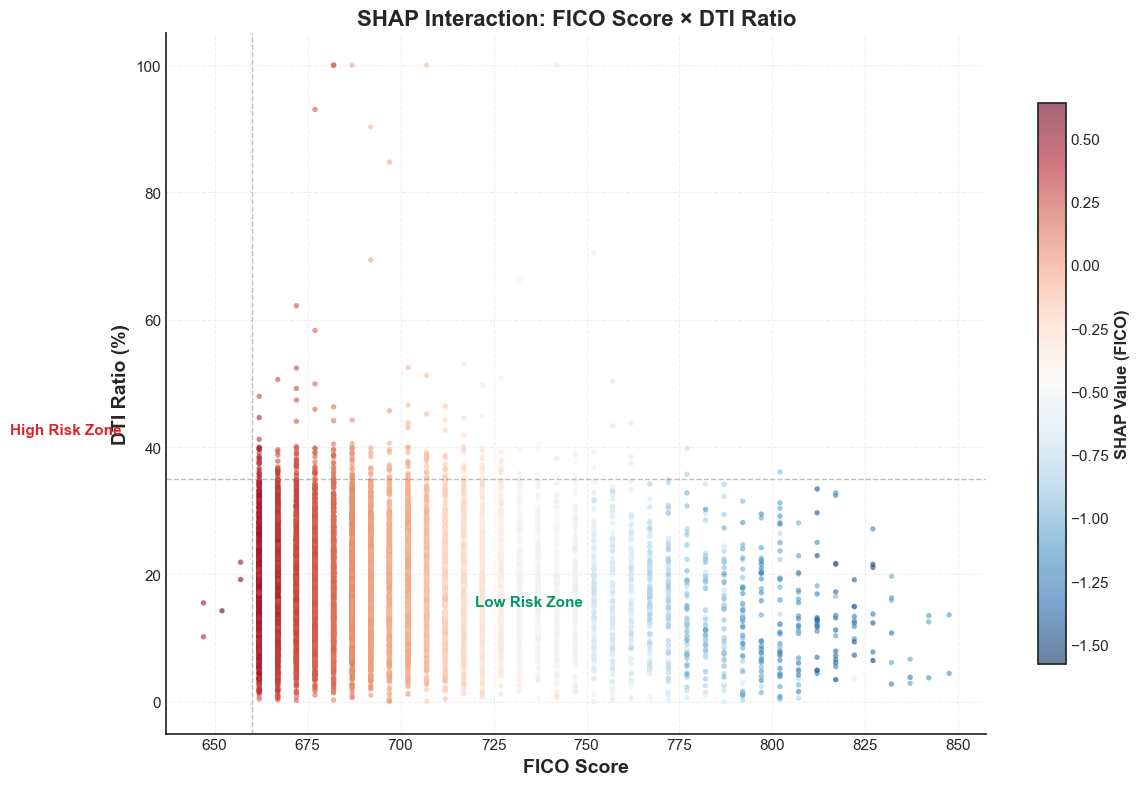

Saved: 28_shap_interaction_fico_dti.png


In [14]:
# FICO vs DTI Interaction
fig, ax = plt.subplots(figsize=(12, 8))

fico_idx = feature_cols.index('fico_n')
dti_idx = feature_cols.index('dti_n')

scatter = ax.scatter(X_sample['fico_n'], X_sample['dti_n'], 
                     c=shap_values[:, fico_idx], cmap='RdBu_r',
                     alpha=0.6, s=15, edgecolors='none')

ax.set_xlabel('FICO Score', fontweight='bold', fontsize=14)
ax.set_ylabel('DTI Ratio (%)', fontweight='bold', fontsize=14)
ax.set_title('SHAP Interaction: FICO Score × DTI Ratio', fontweight='bold', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.3, linestyle='--')

cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('SHAP Value (FICO)', fontweight='bold', fontsize=12)

# Add risk zone annotations
ax.axvline(x=660, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(y=35, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.text(595, 42, 'High Risk Zone', fontsize=11, fontweight='bold', color='#dc2626')
ax.text(720, 15, 'Low Risk Zone', fontsize=11, fontweight='bold', color='#059669')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '28_shap_interaction_fico_dti.png'), dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: 28_shap_interaction_fico_dti.png")

### 4.6 Waterfall Plots - Individual Loan Explanations

In [15]:
# Find representative loans
y_pred_sample = model.predict_proba(X_sample)[:, 1]

high_risk_idx = y_pred_sample.argmax()
low_risk_idx = y_pred_sample.argmin()
median_idx = np.argsort(y_pred_sample)[len(y_pred_sample)//2]

print(f"High Risk PD: {y_pred_sample[high_risk_idx]:.4f}")
print(f"Median PD: {y_pred_sample[median_idx]:.4f}")
print(f"Low Risk PD: {y_pred_sample[low_risk_idx]:.4f}")

High Risk PD: 0.8258
Median PD: 0.4827
Low Risk PD: 0.0303


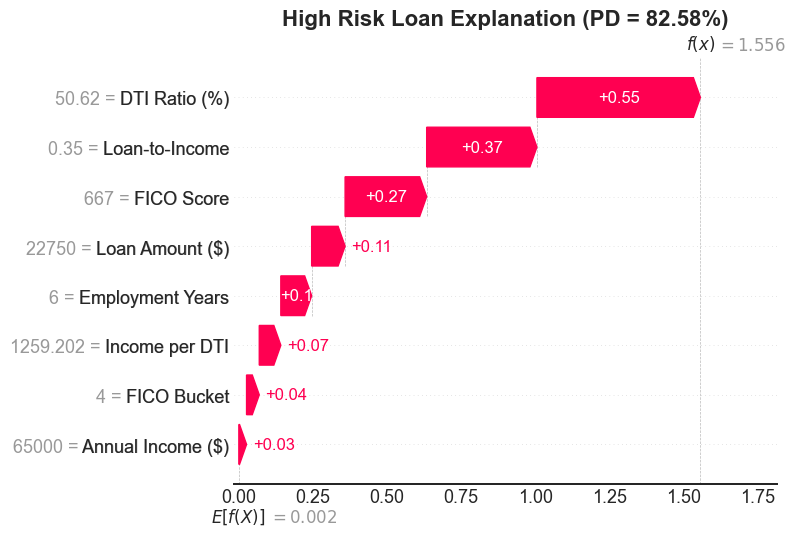

Saved: 29_shap_waterfall_high_risk.png


In [16]:
# High Risk Waterfall
fig = plt.figure(figsize=(14, 8))
shap.plots.waterfall(shap.Explanation(
    values=shap_values[high_risk_idx],
    base_values=explainer.expected_value,
    data=X_sample.iloc[high_risk_idx],
    feature_names=feature_names
), show=False, max_display=8)
plt.title(f'High Risk Loan Explanation (PD = {y_pred_sample[high_risk_idx]:.2%})', 
          fontweight='bold', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '29_shap_waterfall_high_risk.png'), dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: 29_shap_waterfall_high_risk.png")

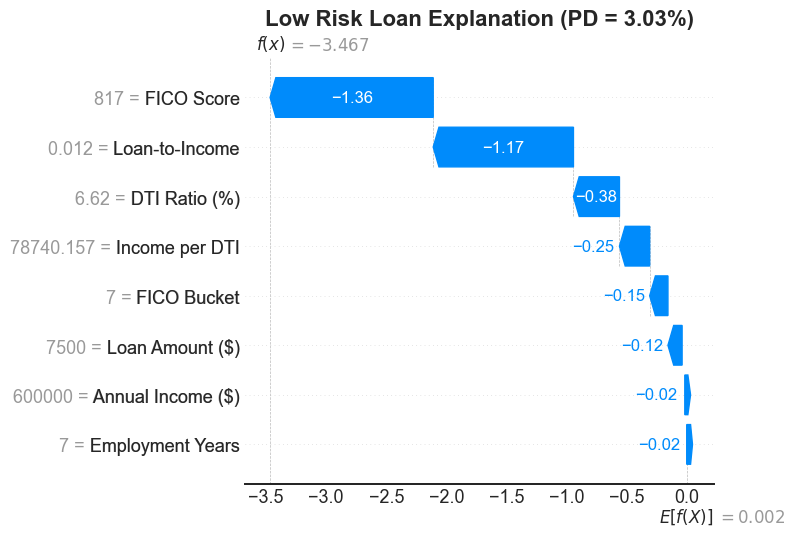

Saved: 30_shap_waterfall_low_risk.png


In [17]:
# Low Risk Waterfall
fig = plt.figure(figsize=(14, 8))
shap.plots.waterfall(shap.Explanation(
    values=shap_values[low_risk_idx],
    base_values=explainer.expected_value,
    data=X_sample.iloc[low_risk_idx],
    feature_names=feature_names
), show=False, max_display=8)
plt.title(f'Low Risk Loan Explanation (PD = {y_pred_sample[low_risk_idx]:.2%})', 
          fontweight='bold', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '30_shap_waterfall_low_risk.png'), dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: 30_shap_waterfall_low_risk.png")

### 4.7 Decision Plot - Prediction Pathways

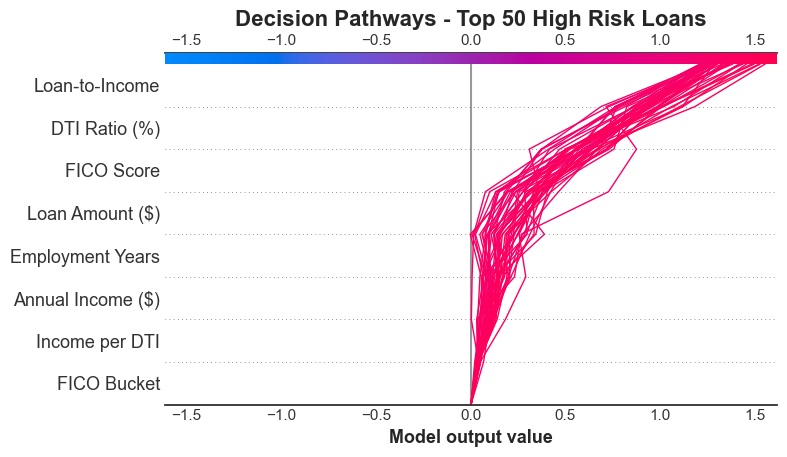

Saved: 31_shap_decision_plot.png


In [18]:
# Decision plot for multiple samples
# Show top 50 highest risk loans
top_risk_idx = np.argsort(y_pred_sample)[-50:]

fig = plt.figure(figsize=(14, 10))
shap.decision_plot(
    explainer.expected_value,
    shap_values[top_risk_idx],
    X_sample.iloc[top_risk_idx],
    feature_names=feature_names,
    show=False
)
plt.title('Decision Pathways - Top 50 High Risk Loans', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '31_shap_decision_plot.png'), dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: 31_shap_decision_plot.png")

### 4.8 Force Plot - Multiple Predictions

In [19]:
# Interactive force plot (HTML)
# Display for a subset of loans
display_idx = np.random.choice(len(X_sample), 100, replace=False)

force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[display_idx],
    X_sample.iloc[display_idx],
    feature_names=feature_names
)

# Save as HTML
shap.save_html(os.path.join(FIGURES_PATH, '32_shap_force_plot.html'), force_plot)
print("Saved: 32_shap_force_plot.html (interactive)")

Saved: 32_shap_force_plot.html (interactive)


### 4.9 Violin Plot - Feature Distribution by Impact

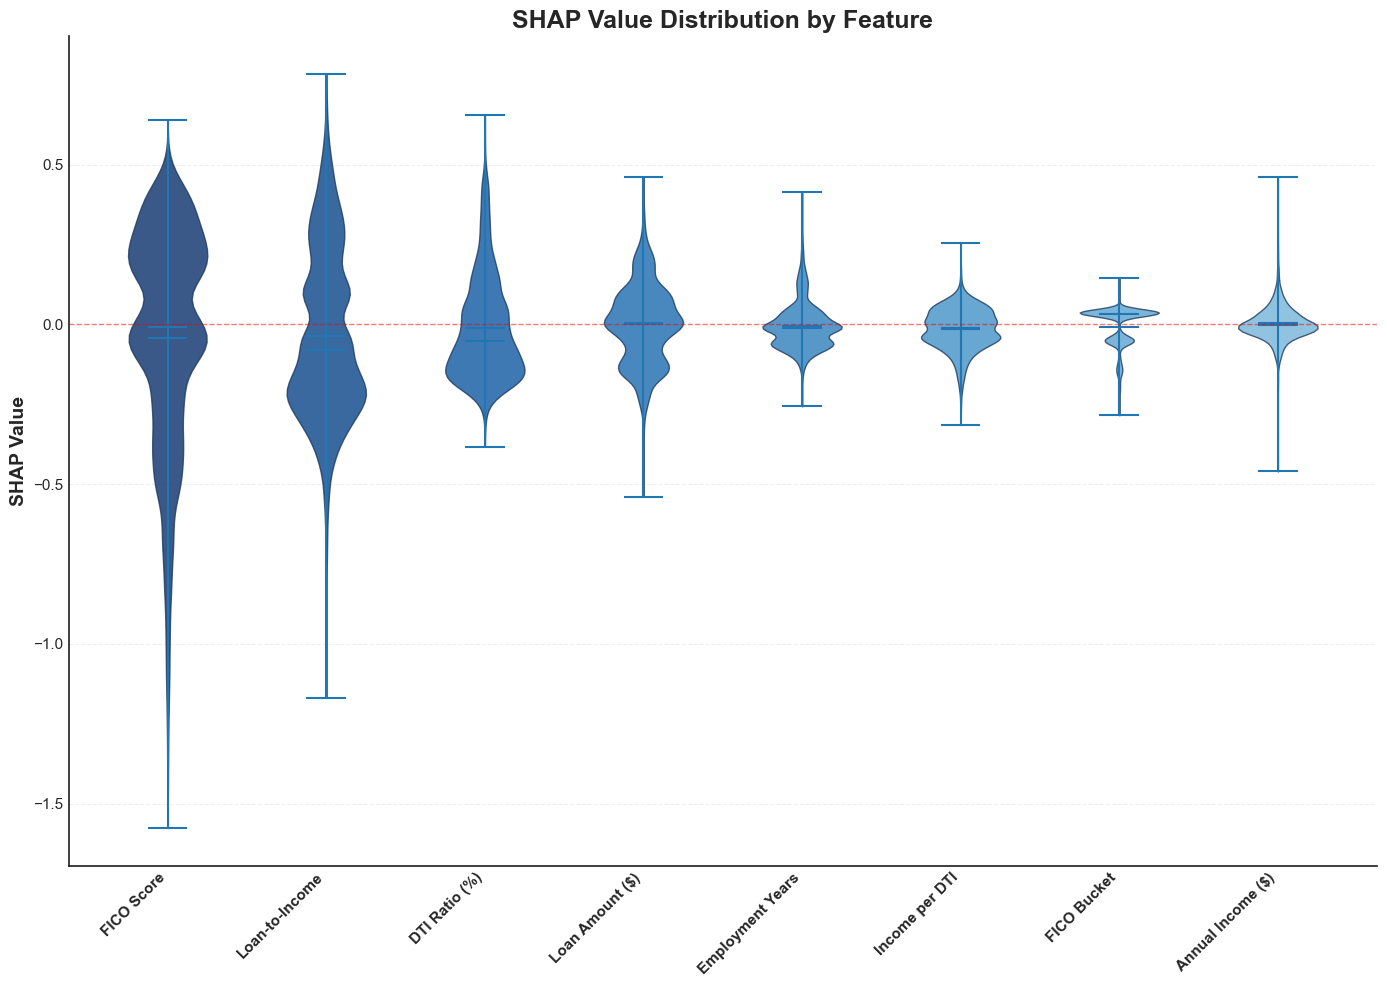

Saved: 33_shap_violin.png


In [20]:
# Custom violin plot showing SHAP value distributions
fig, ax = plt.subplots(figsize=(14, 10))

# Sort features by mean absolute SHAP
sorted_idx = np.argsort(np.abs(shap_values).mean(axis=0))[::-1]

violin_data = [shap_values[:, i] for i in sorted_idx]
sorted_names = [feature_names[i] for i in sorted_idx]

parts = ax.violinplot(violin_data, positions=range(len(sorted_names)), 
                      showmeans=True, showmedians=True)

# Color the violins
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(plt.cm.Blues(0.4 + 0.6 * (len(sorted_names) - i) / len(sorted_names)))
    pc.set_edgecolor('#1e3a5f')
    pc.set_alpha(0.8)

ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax.set_xticks(range(len(sorted_names)))
ax.set_xticklabels(sorted_names, rotation=45, ha='right', fontweight='bold', fontsize=11)
ax.set_ylabel('SHAP Value', fontweight='bold', fontsize=14)
ax.set_title('SHAP Value Distribution by Feature', fontweight='bold', fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '33_shap_violin.png'), dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: 33_shap_violin.png")

### 4.10 Comparison: XGBoost vs SHAP Importance

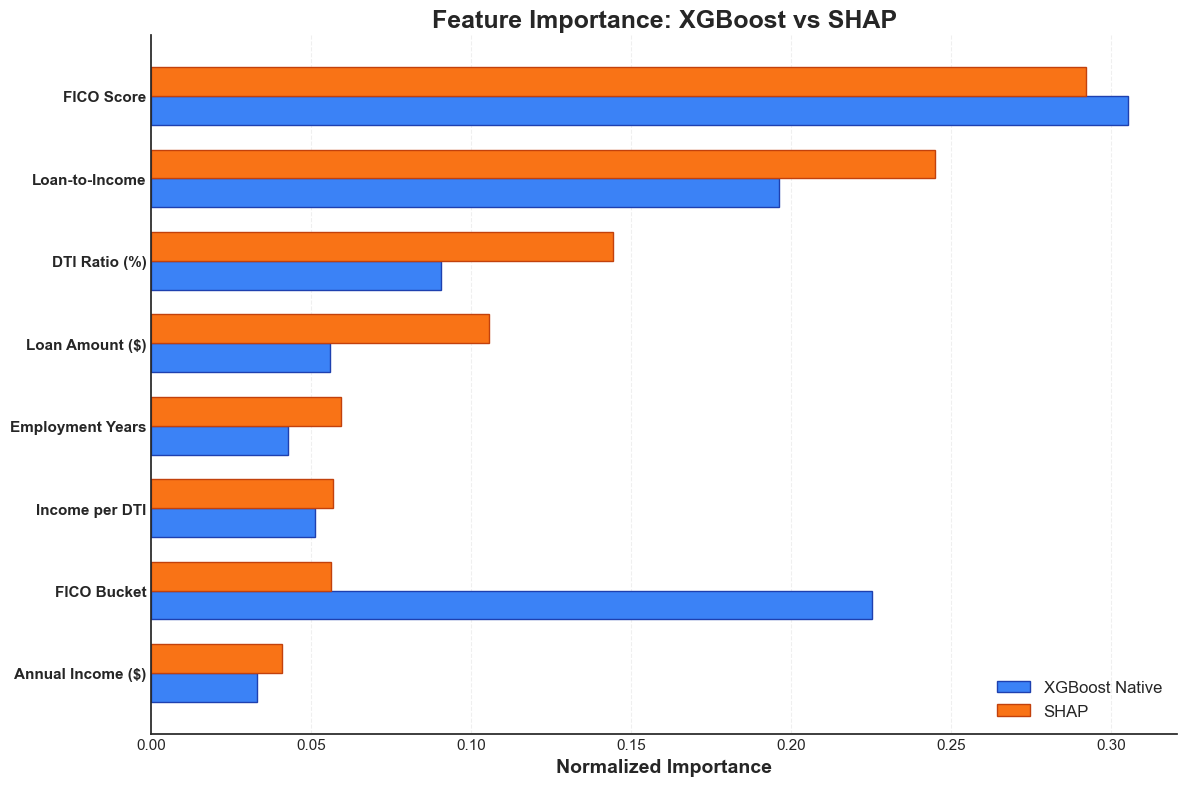

Saved: 34_importance_comparison.png


In [21]:
# Compare native XGBoost importance with SHAP
comparison_df = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost': model.feature_importances_,
    'SHAP': np.abs(shap_values).mean(axis=0)
})

# Normalize for comparison
comparison_df['XGBoost_norm'] = comparison_df['XGBoost'] / comparison_df['XGBoost'].sum()
comparison_df['SHAP_norm'] = comparison_df['SHAP'] / comparison_df['SHAP'].sum()
comparison_df = comparison_df.sort_values('SHAP_norm', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))

y_pos = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.barh(y_pos - width/2, comparison_df['XGBoost_norm'], width, 
                label='XGBoost Native', color='#3b82f6', edgecolor='#1e40af')
bars2 = ax.barh(y_pos + width/2, comparison_df['SHAP_norm'], width,
                label='SHAP', color='#f97316', edgecolor='#c2410c')

ax.set_yticks(y_pos)
ax.set_yticklabels(comparison_df['Feature'], fontweight='bold', fontsize=11)
ax.set_xlabel('Normalized Importance', fontweight='bold', fontsize=14)
ax.set_title('Feature Importance: XGBoost vs SHAP', fontweight='bold', fontsize=18)
ax.legend(fontsize=12, loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, '34_importance_comparison.png'), dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Saved: 34_importance_comparison.png")

## 5. Key Findings Summary

In [22]:
# Generate summary
print("="*80)
print("SHAP ANALYSIS - KEY FINDINGS")
print("="*80)

# Feature rankings
shap_ranking = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP|': np.abs(shap_values).mean(axis=0),
    'Rank': range(1, len(feature_names) + 1)
}).sort_values('Mean |SHAP|', ascending=False)
shap_ranking['Rank'] = range(1, len(shap_ranking) + 1)

print("\n1. FEATURE IMPORTANCE RANKING (by SHAP):")
print("-" * 50)
for _, row in shap_ranking.iterrows():
    print(f"   #{int(row['Rank']):d} {row['Feature']}: {row['Mean |SHAP|']:.4f}")

print(f"\n2. MODEL PERFORMANCE:")
print("-" * 50)
print(f"   AUC-ROC: {auc:.4f}")
print(f"   Gini Coefficient: {2*auc-1:.4f}")

print(f"\n3. KEY INSIGHTS:")
print("-" * 50)
print(f"   - FICO Score: Lower scores → Higher default risk")
print(f"   - DTI Ratio: Higher ratios → Higher default risk")
print(f"   - Income: Lower income → Higher default risk")
print(f"   - Loan Amount: Complex interaction with income")

print(f"\n4. VISUALIZATIONS GENERATED:")
print("-" * 50)
print(f"   - Beeswarm plot (global impact distribution)")
print(f"   - Bar plot (mean importance)")
print(f"   - Heatmap (sample contributions)")
print(f"   - Dependence plots (feature effects)")
print(f"   - Interaction plot (FICO × DTI)")
print(f"   - Waterfall plots (individual explanations)")
print(f"   - Decision plot (prediction pathways)")
print(f"   - Force plot (interactive HTML)")
print(f"   - Violin plot (SHAP distributions)")
print(f"   - Comparison plot (XGBoost vs SHAP)")

print("\n" + "="*80)

SHAP ANALYSIS - KEY FINDINGS

1. FEATURE IMPORTANCE RANKING (by SHAP):
--------------------------------------------------
   #1 FICO Score: 0.2707
   #2 Loan-to-Income: 0.2272
   #3 DTI Ratio (%): 0.1338
   #4 Loan Amount ($): 0.0978
   #5 Employment Years: 0.0548
   #6 Income per DTI: 0.0526
   #7 FICO Bucket: 0.0521
   #8 Annual Income ($): 0.0379

2. MODEL PERFORMANCE:
--------------------------------------------------
   AUC-ROC: 0.6544
   Gini Coefficient: 0.3088

3. KEY INSIGHTS:
--------------------------------------------------
   - FICO Score: Lower scores → Higher default risk
   - DTI Ratio: Higher ratios → Higher default risk
   - Income: Lower income → Higher default risk
   - Loan Amount: Complex interaction with income

4. VISUALIZATIONS GENERATED:
--------------------------------------------------
   - Beeswarm plot (global impact distribution)
   - Bar plot (mean importance)
   - Heatmap (sample contributions)
   - Dependence plots (feature effects)
   - Interaction pl

---

## Summary

This SHAP analysis provides comprehensive model interpretability:

| Analysis Type | Purpose | Key Output |
|--------------|---------|------------|
| Beeswarm | Global feature impact | Feature importance with direction |
| Bar Plot | Mean importance | Simple ranking |
| Heatmap | Cross-sample patterns | Portfolio-wide trends |
| Dependence | Feature effects | Non-linear relationships |
| Interaction | Feature combinations | Risk factor combinations |
| Waterfall | Individual explanations | Loan-level reasoning |
| Decision | Prediction pathways | Model decision logic |

**Regulatory Value:** SHAP explanations support SR 11-7 model risk management requirements by providing transparent, quantifiable feature contributions for every prediction.

---